In [1]:
import numpy as np
import scipy as sc
from matplotlib import pyplot as plt
import colour
import cv2
import random
import os
import random
import torch

device = 'cuda' if torch.cuda.is_available else 'cpu'

c:\programdata\miniconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\programdata\miniconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\programdata\miniconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
import menon

In [44]:
with open('./sample_names.txt', 'r') as f:
    sample_names = eval(f.read())
s_name = f'./data3/{random.choice(sample_names)}'

In [45]:
sample = np.load(f"{s_name}", allow_pickle=True).item()

In [46]:
sample_img   = sample['image']
sample_cmfs  = sample['cmfs']
sample_light = sample['light']
sample_bayer = sample['bayer']
sample_mean  = sample['mean']
sample_sigma = sample['sigma']

## Debayering

In [47]:
img = menon.bayer2rgb(sample_img/255, pattern=sample_bayer)
img_shape = img.shape

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


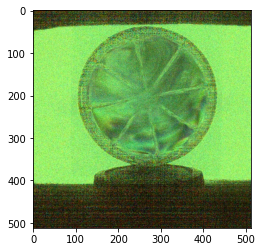

In [48]:
plt.imshow(img)

## Denoising

In [49]:
import sys
sys.path.append('./KAIR/')
from KAIR.models.network_dncnn import DnCNN

In [86]:
model = DnCNN(in_nc=1, out_nc=1, nc=64, nb=17, act_mode='R')
model.load_state_dict(torch.load('./KAIR/model_zoo/dncnn_15.pth'))

<All keys matched successfully>

In [51]:
imgT = torch.transpose(torch.tensor(img, dtype=torch.float32), 0, 2)

In [52]:
imgT = imgT.to(device)
model = model.to(device)
with torch.no_grad():
    denoised = model(imgT.unsqueeze(1))
    denoised = denoised.squeeze_()

In [90]:
model = model.to(device)
with torch.no_grad():
    denoised_r = model(img_xyz.unsqueeze(1))
    denoised_r = denoised_r.squeeze_()

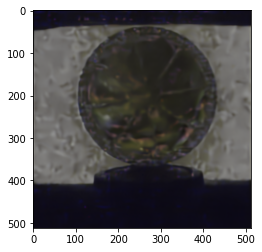

In [91]:
plt.imshow(torch.transpose(denoised_r, 0, 2).detach().cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


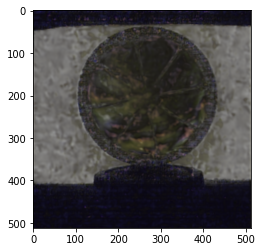

In [92]:
plt.imshow(torch.transpose(img_xyz, 0, 2).detach().cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


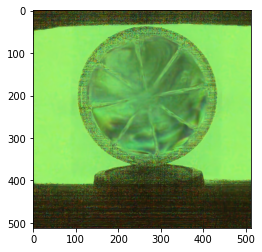

In [53]:
plt.imshow(torch.transpose(denoised, 0, 2).detach().cpu())

## Переход в CIE XYZ

In [54]:
from torch import nn

In [55]:
model = nn.Sequential(
    nn.Conv2d(3, 16, 3, padding='same'),
    nn.LeakyReLU(),
    nn.Conv2d(16, 16, 3, padding='same'),
    nn.LeakyReLU(),
    nn.Conv2d(16, 16, 3, padding='same'),
    nn.LeakyReLU(),
    nn.Conv2d(16, 3, 3, padding='same')
).to(device)

In [68]:
model.load_state_dict(torch.load('./CST_142.pth'))

<All keys matched successfully>

In [69]:
with torch.no_grad():
    img_xyz = model(denoised)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


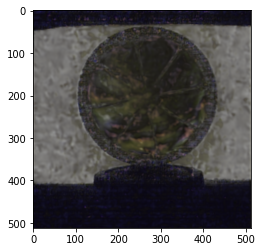

In [70]:
plt.imshow(torch.transpose(img_xyz, 0, 2).detach().cpu())

## Компенсация освещения

### Max RGB

In [71]:
light = img_xyz.max(dim=2).values.max(dim=1).values

In [72]:
res = torch.transpose(img_xyz, 0, 2).cpu()/light.cpu()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


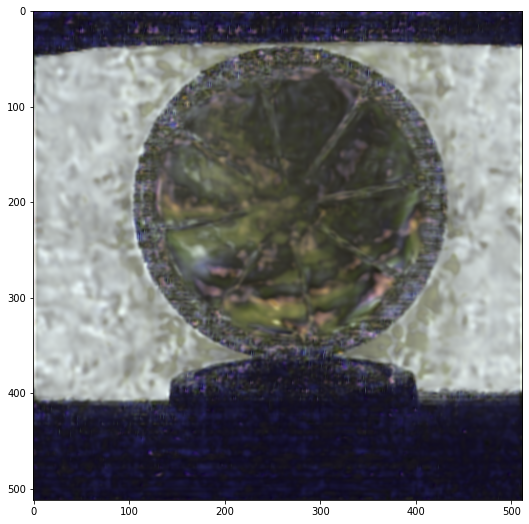

In [73]:
plt.figure(figsize=(16,9))
plt.imshow(res)

In [74]:
s_name[:-10]+'gt.npy'

'./data3/2019-09-12_005_gt.npy'

In [75]:
gt = np.load(s_name[:-10]+'gt.npy', allow_pickle=True).item()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


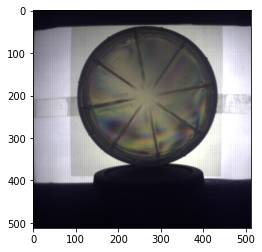

In [76]:
plt.imshow(gt['xyz'])

In [77]:
import XYZ_to_SRGB

In [78]:
XYZ_TO_SRGB = XYZ_to_SRGB.XYZ_TO_SRGB()

In [83]:
img_srgb = XYZ_to_SRGB.XYZ_TO_SRGB().XYZ_to_sRGB(res.numpy())

C:\Users\vsevo\Desktop\vuz\CCV23.HSE\Hackaton\XYZ_to_SRGB.py:29: UserWarning: ffs, the range should be in [0, 1] not [-0.072317 1.326889]
  warnings.warn(


In [93]:
plt.imsave(s_name[:-3]+'.png', img_srgb)

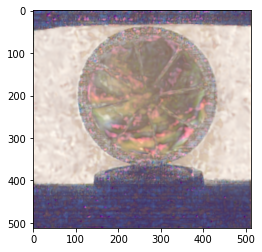

In [84]:
plt.imshow(img_srgb)

In [95]:
class f():
    f.in = 10

SyntaxError: invalid syntax (Temp/ipykernel_5388/660475913.py, line 2)

In [96]:
import argparse

In [99]:
parser = argparse.ArgumentParser(prog='Image processing pipeline', description='converts all files inside --inf folder to pngs in --out folder, --denoise-weights to specify path to weights for KAIR denoising DnCNN, --cst-weights to specify path to cst model weights',)
parser.add_argument('-i', '--inf')
parser.add_argument('-o', '--out')
parser.add_argument('-d', '--denoise-weights')
parser.add_argument('-c', '--cst-weights')
parser.add_argument('-f')
args = parser.parse_args()

In [100]:
args.

Namespace(inf=None, out=None, denoise_weights=None, cst_weights=None, f='C:\\Users\\vsevo\\AppData\\Roaming\\jupyter\\runtime\\kernel-8625303a-eef7-45dc-aafb-d6fc7458ee21.json')